## Training Risk-Aware-VAE

### 1: Load MNIST as example

In [1]:
import torch
from dataset import read_mnist
from torch.utils.data import DataLoader

torch.manual_seed(2)

In [2]:
mnist_train, mnist_val, mnist_test = read_mnist()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

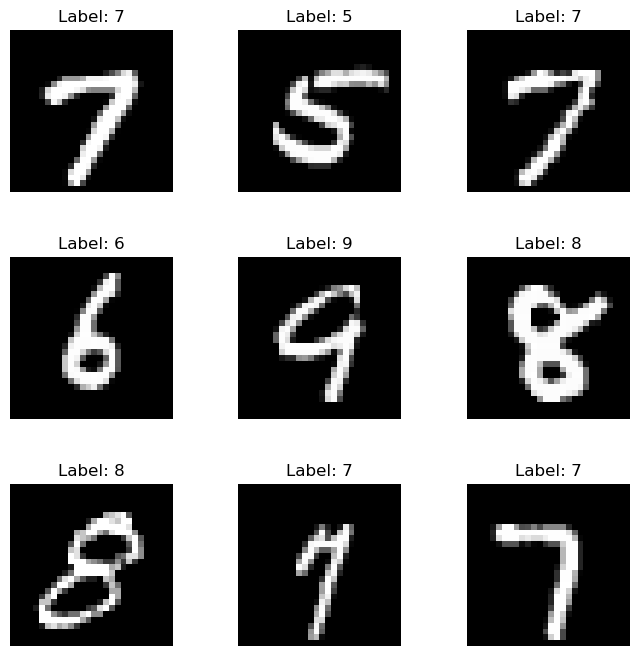

In [3]:
# some visualizations
from utils import visualize_dataset_in_grid

train_dataloader = DataLoader(mnist_train, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))
visualize_dataset_in_grid(train_features, train_labels)

### 2: Experiments

In [4]:
from backbone import VAE, vanilla_config, two_layer_config
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="gray")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def generate_img(model, z_dim):
    with torch.no_grad():
        z = torch.randn(64, z_dim).cuda()
        sample = model.model.decode(z)

    img_grid = make_grid(sample.view(64, 1, 28, 28).cpu())
    matplotlib_imshow(img_grid, one_channel=True)
    
def reconstruct_img(model, x):    
    with torch.no_grad():
        sample, _, _ = model.model.forward(x.reshape(1, -1).cuda())
    
    imgs = torch.cat((x.view(1, 1, 28, 28).cpu(), sample.view(1, 1, 28, 28).cpu()))
    img_grid = make_grid(imgs)
    matplotlib_imshow(img_grid, one_channel=True)
    plt.show()
    
def train_mnist(z_dim, config, risk_aware, epochs=10, risk_q=0.5, show_config=True, plot=True):
    model = VAE(28 * 28, z_dim, config, device=device, risk_aware=risk_aware, risk_q=risk_q)
    if show_config:
        print(model.model)
    model.fit(mnist_train, mnist_val, epochs=epochs)
    if plot:
        plt.subplot(1, 2, 1)
        generate_img(model, z_dim)
        plt.subplot(1, 2, 2)
        reconstruct_img(model, train_features[0])
        plt.show()
    return model

VNet(
  (enc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (mu_enc): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (var_enc): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 93.17it/s]


Epoch: 1, train loss: 179.6962, dev loss: 164.9757


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:07<00:00, 94.08it/s]


Epoch: 2, train loss: 160.6398, dev loss: 157.8118


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 92.75it/s]


Epoch: 3, train loss: 155.4857, dev loss: 154.5481


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 91.80it/s]


Epoch: 4, train loss: 152.5300, dev loss: 151.7819


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 90.25it/s]


Epoch: 5, train loss: 150.2189, dev loss: 150.3393


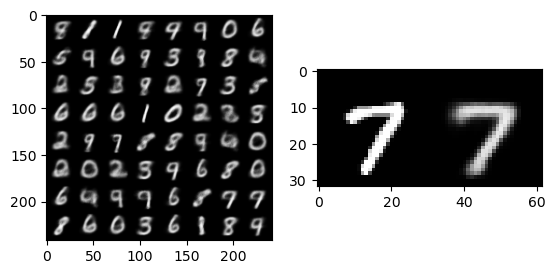

In [5]:
vae_model = train_mnist(2, two_layer_config, risk_aware="neutral", epochs=5)

VNet(
  (enc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (mu_enc): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (var_enc): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 87.00it/s]


Epoch: 1, train loss: 139.6798, dev loss: 123.5515


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 83.32it/s]


Epoch: 2, train loss: 119.2660, dev loss: 116.5811


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 76.62it/s]


Epoch: 3, train loss: 113.3762, dev loss: 112.3407


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:10<00:00, 72.92it/s]


Epoch: 4, train loss: 109.8430, dev loss: 108.9664


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 78.11it/s]


Epoch: 5, train loss: 107.5455, dev loss: 107.0992


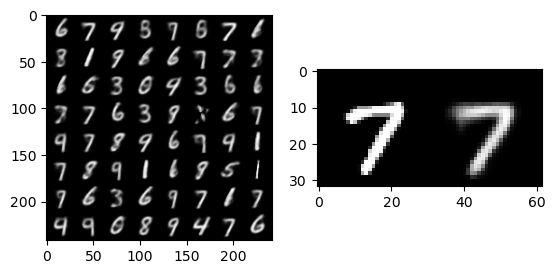

In [6]:
vae_rs = train_mnist(2, two_layer_config, risk_aware="seeking", epochs=5)

VNet(
  (enc): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (mu_enc): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (var_enc): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
  )
  (dec): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
    (5): Sigmoid()
  )
)


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 86.72it/s]


Epoch: 1, train loss: 212.7552, dev loss: 195.3021


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:08<00:00, 85.62it/s]


Epoch: 2, train loss: 191.8712, dev loss: 189.4563


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 76.50it/s]


Epoch: 3, train loss: 188.0991, dev loss: 187.3712


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:09<00:00, 76.26it/s]


Epoch: 4, train loss: 185.7132, dev loss: 185.1138


100%|████████████████████████████████████████████████████████████████████████████████| 750/750 [00:10<00:00, 73.55it/s]


Epoch: 5, train loss: 183.3956, dev loss: 183.0772


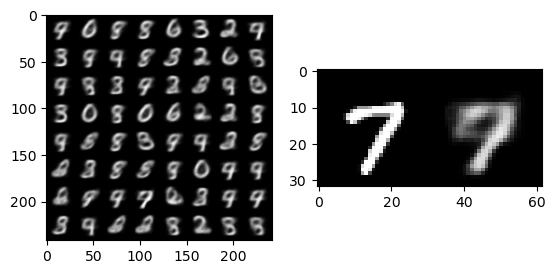

In [7]:
vae_ra = train_mnist(2, two_layer_config, risk_aware="abiding", epochs=5)

### 3: (WIP) Further Experiments: Inception Score and FID

Requires: torchmetrics, torch-fidelity

To-do: functions for generating images, computing IS and FID

In [32]:
from torchmetrics.image.inception import InceptionScore
from torchmetrics.image.fid import FrechetInceptionDistance

In [29]:
with torch.no_grad():
    z = torch.randn(64, 2).cuda()
    sample = vae_model.model.decode(z)

In [ ]:
inception = InceptionScore(normalize=True)
inception.update(sample.view(64, 1, 28, 28).cpu().repeat(1, 3, 1, 1))
inception.compute()

In [ ]:
with torch.no_grad():
    sample, _, _ = vae_model.model.forward(train_features[0].reshape(1, -1).cuda())

In [ ]:
# How to reconstruct a batch of samples instead of 1
fid = FrechetInceptionDistance(feature=64, normalize=True)
img_dist1 = train_features[0].view(1, 1, 28, 28).cpu().repeat(100, 3, 1, 1)
img_dist2 = sample.view(1, 1, 28, 28).cpu().repeat(100, 3, 1, 1)
fid.update(img_dist1, real=True)
fid.update(img_dist2, real=False)
fid.compute()